In this notebook we'll solve the Bernoulli Bandits problem using the QCLP formulation presented in the paper below:
https://www.ijcai.org/Proceedings/07/Papers/389.pdf

I'll also be borrowing from this video and the code presented in it:
https://www.youtube.com/watch?v=8GuQAfyvWYc&list=PLRwcSE2bmyBxc9u_tV65sZTGy729nqgiv&index=16&ab_channel=ICTPQuantitativeLifeSciences

In [4]:
from pyomo.environ import *
from itertools import product
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import sys
# append a new directory to sys.path
sys.path.append("c:\\Users\\Tassili\\Desktop\\FSC-optimization-main")
from QCLP_formulation import qclp_formulation
import networkx as nx

# Two-armed Bernoulli Bandits...

  Credits: Andrea Mazzolini, Alberto Pezzotta 

In the standard "two-armed Bernoulli Bandits" we can pull one of the two arms of a bandit (slot-machine) $a\in \lbrace 1,2 \rbrace$. Both the arms provide a Bernoulli-distributed reward: $r = 1$ with probability $q_i$, $r = 0$ with $1-q_i$, where $i \in \lbrace 1,2 \rbrace$.

<div>
<img src="Bandits.PNG" width="400">
</div>

In the most general case, there is a whole 2D space of possible bandits.
Each point correspond to a single state, that is a single realization of the two-bandits above.

<div>
<img src="BeliefSpace.PNG" width="400">
</div>
Solving each problem is trivial: we just use the arm with larger success probability.

In our case we'll choose to focus on two symmetric states (A,B) of this square where we have the following probabilities:  
  Probability of winning in state A having chosen action (arm) 1: $P(r = 1 \,|\, s= A, a=1) = \theta$   
  Probability of winning in state A having chosen action (arm) 2: $P(r = 1 \,|\, s= A, a=2) = 1 - \theta$   
  Probability of winning in state B having chosen action (arm) 1: $P(r = 1 \,|\, s= B, a=1) = 1 - \theta$   
  Probability of winning in state B having chosen action (arm) 2: $P(r = 1 \,|\, s= B, a=2) = \theta$   

Upon choosing $\theta$ we get the two states:

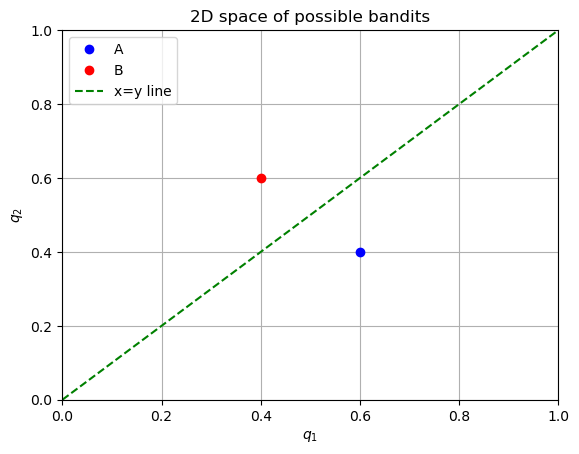

In [5]:
thetatest = 0.6
# Define the coordinates of the two points
point1 = (thetatest, 1- thetatest)
point2 = (1- thetatest, thetatest)

# Extract x and y coordinates of each point
x1, y1 = point1
x2, y2 = point2

# Plot the points
plt.plot(x1, y1, 'bo', label='A')
plt.plot(x2, y2, 'ro', label='B')
plt.plot([0, 1], [0, 1], 'g--', label='x=y line')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

# Show plot
plt.show()


Following this we define our POMDP parameter values

In [6]:
#Define POMDP parameters

num_states = 2 # Number of states
num_actions = 2 # Number of actions
num_observations = 2 # Number of observations

s = list(range(num_states))  # state A & B
a = list(range(num_actions)) # pull arm 1 or pull arm 2
o = list(range(num_observations))  # recieve reward 1 or 0

b0 = np.ones((num_states)) / num_states # uniform initial distribution over states
gamma = 0.5 # Discount factor 
theta = 0.8 # Bernoulli parameter for the reward

# P(s'|s,a) in this case equals 1 when s' = s and 0 otherwise
state_transition_model = np.zeros((num_states, num_actions, num_states)) 
for state, sprime, action in product(s,s,a):
    if state ==  sprime:
        state_transition_model[sprime, action, state] = 1

# R(s,a), since the reward is stochastic we take instead the average reward for each arm and state
reward_model = np.zeros((num_states, num_actions))
# state A
reward_model[0, 0], reward_model[0, 1] = theta, 1 - theta
# state B
reward_model[1, 0], reward_model[1, 1] = 1 - theta, theta

def bernoulliprob(p,y):
    return p**y * (1-p)**(1-y)

# O(o|s',a) the probability of observing reward o in state s' after taking action a
observation_model = np.zeros((num_states, num_actions, num_observations)) 
for state, action, observation in product(s,a,o):
    if state == action:
        observation_model[state,action,observation] = bernoulliprob(theta, observation)
    else:
        observation_model[state,action,observation] = bernoulliprob(1-theta, observation)


Visualizing POMDP parameter values

In [7]:
def statename(state):
    return 'A' if state == 0 else 'B'
state_transition_model_dict = {
    str((statename(sprime),action +1,statename(state))): state_transition_model[sprime,action,state]
    for sprime,action,state in product(s,a,s)
}
state_transition_model_df = pd.DataFrame(state_transition_model_dict, index=['Transition probability']) 
state_transition_model_df = state_transition_model_df.rename_axis("(s',a,s)", axis="columns")
state_transition_model_df

"(s',a,s)","('A', 1, 'A')","('A', 1, 'B')","('A', 2, 'A')","('A', 2, 'B')","('B', 1, 'A')","('B', 1, 'B')","('B', 2, 'A')","('B', 2, 'B')"
Transition probability,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [8]:
rewarddf = pd.DataFrame(reward_model, index=['A', 'B'], columns=['Arm 1', 'Arm 2'])
rewarddf.rename_axis("state", axis="index")

,Arm 1,Arm 2
state,,
A,0.8,0.2
B,0.2,0.8


In [9]:
observation_model_dict = {
    (str((statename(sprime),action +1,observation))): observation_model[sprime,action,observation]
    for sprime,action,observation in product(s,a,o) }
observation_model_df = pd.DataFrame(observation_model_dict, index=['Observation probability'])
observation_model_df.rename_axis("(s',a,o)", axis="index")

,"('A', 1, 0)","('A', 1, 1)","('A', 2, 0)","('A', 2, 1)","('B', 1, 0)","('B', 1, 1)","('B', 2, 0)","('B', 2, 1)"
"(s',a,o)",,,,,,,,
Observation probability,0.2,0.8,0.8,0.2,0.8,0.2,0.2,0.8


Finite state controller

In [10]:
num_nodes = 2
q = list(range(num_nodes)) # Nodes in the FSC


# QCLP formulation
<div>
<img src="QCLP formulation.PNG" width="850">
</div>

Where:  
The variable $x(q', a, q, o)$ represents $P(q', a|q, o)$  
The variable $y(q, s)$ represents $V(q, s)$  
$q_0$ is the initial controller node  
$o_k$ is an arbitrary fixed observation  

Note that $P(q', a|q, o)= P(q'|q, o) P(a|q)$ 

And $\sum{q'} P(q', a|q, o) = P(a|q)$

In [11]:
newmodel = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)

### Win-Stay Lose_Shift initial values

In [12]:
def win_stay_lose_shift(num_nodes,newmodel):
    # initial values for the variables with Win-Stay Lose-Shift policy
    if num_nodes == 2:
        for qnode in newmodel.q:
            for actionn in newmodel.a:
                for qnodeprime in newmodel.q:
                    for obs in newmodel.o:
                        if qnode == qnodeprime and qnode == actionn and obs == 1:
                            newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                            # print(f"being in {qnode} having chosen {actionn} and observed {obs} we stay in {qnodeprime}", newmodel.x[qnodeprime,actionn,qnode,obs].value)
                        elif qnode != qnodeprime and qnode == actionn and obs == 0:
                            newmodel.x[qnodeprime,actionn,qnode,obs] = 1 
                            # print(f"being in {qnode} having chosen {actionn} and observed {obs} we shift to {qnodeprime}",newmodel.x[qnodeprime,actionn,qnode,obs].value)
                        else:
                            newmodel.x[qnodeprime,actionn,qnode,obs] = 0
                            # print(f"being in {qnode} having chosen {actionn} and observed {obs} we don't go to {qnodeprime}",newmodel.x[qnodeprime,actionn,qnode,obs].value)
        newmodel.x.pprint() 

In [36]:
opt = SolverFactory('ipopt')
# opt.options["print_user_options"] = "yes"
# opt.options["print_options_documentation"] = "yes"
es = opt.solve(newmodel) 
# print(res.write())
# opt.solve(newmodel, tee=True).write()
# newmodel.display()
# newmodel.y.pprint()
# newmodel.x.pprint()
# newmodel.pprint()

# Creating Solution dataframes

In [34]:
def value_dataframe(newmodely,horiz=False):
    optimal_y = {"(q,s)": [key for key in newmodely.get_values().keys()],
                  "V(q,s)": [newmodely.get_values()[key] for key in newmodely.get_values().keys()]}
    if horiz:
        optimal_y_df = pd.DataFrame(optimal_y).T   
        # specify column names
        optimal_y_df.columns = optimal_y_df.iloc[0]
        # drop extra row
        optimal_y_df = optimal_y_df.drop(optimal_y_df.index[0])
        # add mean value
        optimal_y_df.insert(len(optimal_y_df.columns),"mean value",float(optimal_y_df.mean(axis=1)[0]))
    else:
        optimal_y_df = pd.DataFrame(optimal_y)
        # set index
        optimal_y_df = optimal_y_df.set_index("(q,s)")
        # add mean value
        optimal_y_df.loc["mean value"] = float(optimal_y_df.mean(axis=1)[0])
    return optimal_y_df

optimal_ydf = value_dataframe(newmodel.y,horiz=True)
optimal_ydf

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)",mean value
"V(q,s)",1.0,1.0,1.0,1.0,1.0


In [17]:
value_WSLS = [{"(q,s)":(qi,si), "V_WSLS(q,s)": 1.47 if qi == si else 0.87}
            for (qi,si) in product(range(2),range(2))]
value_WSLSdf = pd.DataFrame(value_WSLS).T
value_WSLSdf.columns = value_WSLSdf.iloc[0]
value_WSLSdf.drop(value_WSLSdf.index[0], inplace=True)
value_WSLSdf.insert(len(value_WSLSdf.columns),"mean value",float(value_WSLSdf.mean(axis=1)[0]))
value_WSLSdf

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)",mean value
"V_WSLS(q,s)",1.47,0.87,0.87,1.47,1.17


In [35]:
def actionselect_nodetrans(newmodelx, horiz_action = False, horiz_trans = False):
    nodetrans = {}
    actionselect = {}

    for key in newmodel.x.get_values():
        index = key[1:]
        actionselect[key[1:3]] = sum(newmodel.x.get_values()[key] for key in newmodel.x.get_values() if key[1:] == index)
        nodetrans[key] = 0 
        if actionselect[key[1:3]] != 0:
            nodetrans[key] = newmodel.x.get_values()[key] / actionselect[key[1:3]]
    
    
    actionselectdict = [{"(a,q)": key, "P(a | q)": actionselect[key]}for key in actionselect.keys()]
    if horiz_action:
        actionselectdf = pd.DataFrame(actionselectdict).T
        actionselectdf.columns = actionselectdf.iloc[0]
        actionselectdf.drop(actionselectdf.index[0], inplace=True)
    else:
        actionselectdf = pd.DataFrame(actionselectdict)
        actionselectdf = actionselectdf.set_index("(a,q)")
    
    nodetransdict = [{"(q',a,q,o)": key, "P(q' | q, a, o)": round(nodetrans[key],3), "P(q',a | q,o)": round(value(newmodel.x[key]),3)}for key in nodetrans.keys()]
    nodetransdf = pd.DataFrame(nodetransdict)
    nodetransdf.set_index("(q',a,q,o)", inplace=True)
    if horiz_trans:
        nodetransdf = pd.DataFrame(nodetransdict).T
        nodetransdf.columns = nodetransdf.iloc[0]
        nodetransdf.drop(nodetransdf.index[0], inplace=True)
    else:
        nodetransdf = pd.DataFrame(nodetransdict)
        nodetransdf.set_index("(q',a,q,o)", inplace=True)
    
    return actionselectdf, nodetransdf

adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action=True,horiz_trans=False)
adf

"(a,q)","(0, 0)","(0, 1)","(1, 0)","(1, 1)"
P(a | q),0.5,0.5,0.5,0.5


# Graph visualizations

[(6.123233995736766e-17, 1.0), (-0.8660254037844388, -0.4999999999999997), (0.8660254037844384, -0.5000000000000004)]


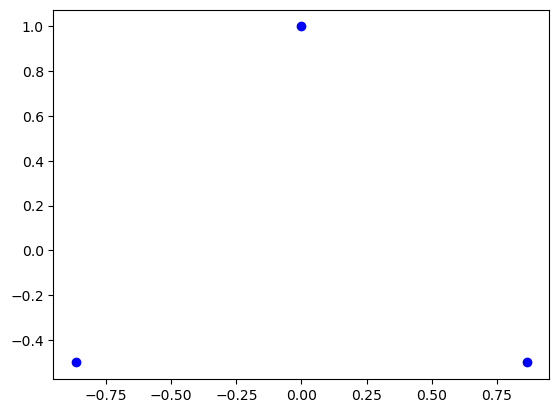

In [676]:
def action_node_pos(number_actions,origin, radius = 1, angle = 0):
    angle_increment = np.divide(np.multiply(2 , np.pi) , number_actions)
    action_pos = []
    for i in range(number_actions):
        action_pos.append((np.multiply(np.cos(angle),radius)+origin[0], np.multiply(np.sin(angle),radius) + origin[1]))
        angle += angle_increment
    return action_pos

l = action_node_pos(3, (0,0), angle = np.pi/2)
print(l)
for i in l:
    plt.plot(i[0], i[1], 'bo')

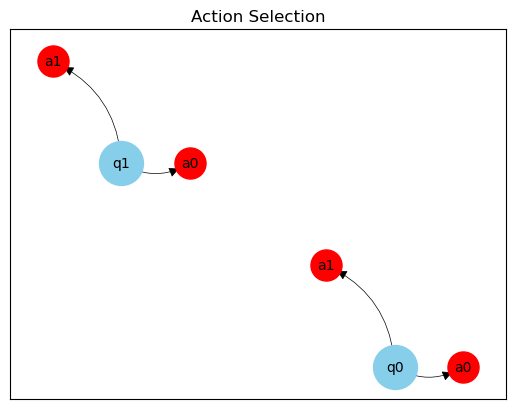

In [677]:
nodes = [ "q" + str(i) for i in q]
states = ["s" + str(i) for i in s]
actions = ["a" + str(i) for i in a]
observations = ["o" + str(i) for i in o]

# Create action selection graph
G = nx.MultiDiGraph() # multi directed graph
print()
# action node list
actionnodelist = []

# dictionary for labels
labels_dict = {}

for qnode in nodes:
    G.add_node(qnode)
    labels_dict[qnode] = qnode
    for actionnode in actions:
        G.add_node((actionnode, qnode))
        actionnodelist.append((actionnode, qnode))
        labels_dict[(actionnode, qnode)] = actionnode
        G.add_edge(qnode, (actionnode, qnode), probability = actionselect[(int(actionnode[1]), int(qnode[1]))])

# radius surrounding origin for controller nodes
radius1 = 1
# radius surrounding controller node for action nodes
radius2 = 0.5

qnodepos = action_node_pos(len(nodes),origin = (0,0), radius = radius1)

pos = {}

for qnode in nodes:
    pos[qnode] = qnodepos.pop(0)
    i = 0
    # position action nodes surrounding the controller node
    actionnodepos = action_node_pos(len(actions), pos[qnode], radius = radius2)
    for actionnode in actions:
        pos[(actionnode, qnode)] = actionnodepos[i]
        i += 1

# Draw nodes
# controller nodes
nx.draw_networkx_nodes(G, pos,nodes, node_size=1000, node_color='skyblue')
# action nodes
nx.draw_networkx_nodes(G, pos,actionnodelist, node_size=500, node_color='red')

 
# Draw edges
widthlist = [G[e[0]][e[1]][0]['probability'] for e in G.edges]
nx.draw_networkx_edges(G, pos, width=widthlist, arrows=True,  connectionstyle='arc3, rad = 0.3', arrowsize = 15)

# Draw labels
nx.draw_networkx_labels(G, pos,labels = labels_dict, font_size=10, font_family="sans-serif")


plt.title('Action Selection')
plt.show()


[(0.25, 0), (-0.25, 0), (0.75, 0), (-0.75, 0), (1.25, 0), (-1.25, 0)]


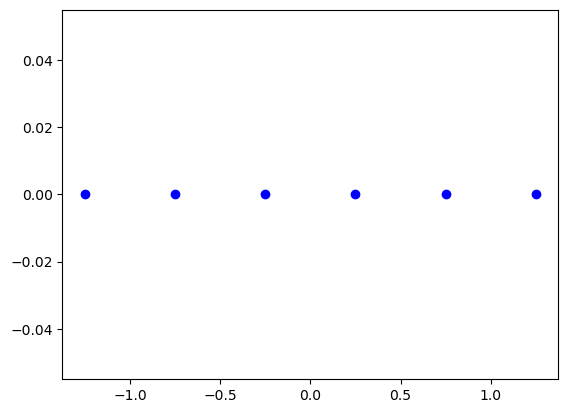

In [678]:
def horiz_pos(number_nodes, space = 1, origin = (0,0)):
    qnode_pos_list = []
    if number_nodes % 2 == 0:
        qnode_pos_list.append((origin[0] + space * 0.5, origin[1]))
        qnode_pos_list.append((origin[0] - space * 0.5, origin[1]))
        for i in range(1,number_nodes //2):
            qnode_pos_list.append((qnode_pos_list[0][0] + (i)* space, qnode_pos_list[0][1] ))
            qnode_pos_list.append((qnode_pos_list[1][0] - (i)*space, qnode_pos_list[1][1] ))
    else:
        qnode_pos_list.append(origin)
        for i in range(number_nodes // 2):
            qnode_pos_list.append((origin[0] + (i+1) * space, origin[1] ))
            qnode_pos_list.append((origin[0] - (i+1) * space, origin[1] ))
    return qnode_pos_list
    
l = horiz_pos(6, space = 0.5, origin = (0,0))
print(l)
for i in l:
    plt.plot(i[0], i[1], 'bo', label='A')

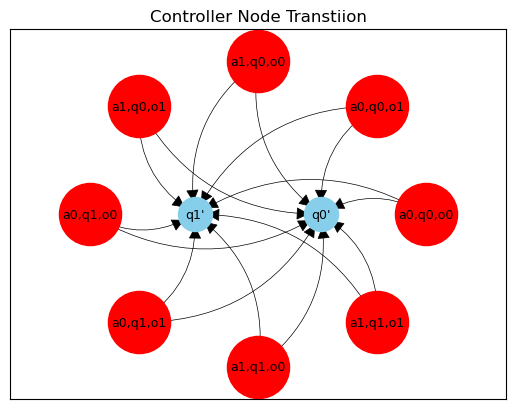

In [679]:
nodesprime = [qnode + "\'" for qnode in nodes]
# create transition graph
G1 = nx.MultiDiGraph() 

# create controller nodes (q')
for qprime in nodesprime:
    G1.add_node(qprime)
    
# transition node list
transnodelist = []

# create (a,q,o) nodes and add edges to q' nodes
for qnode in nodes:
    for actionnode in actions:
        for observation in observations:
            G1.add_node((actionnode, qnode, observation))
            transnodelist.append((actionnode, qnode, observation))
            for qprime in nodesprime:
                G1.add_edge((actionnode, qnode, observation), qprime , probability = nodetrans[(int(qprime[1]), int(actionnode[1]), int(qnode[1]), int(observation[1]))])

# positions for controller nodes (q')
space_nodes = 1
# position nodes horizontally with space_nodes between them
nodepos = horiz_pos(len(nodes), space = space_nodes)
for qprime in nodesprime:
    pos[qprime] = nodepos.pop(0)

# positions for (a,q,o) nodes
radius = len(nodesprime) * space_nodes / 1.5
# position (a,q,o) nodes circularly around the controller nodes (q')
nodetranspos = action_node_pos(len(actions)* len(nodes) * len(observations), (0,0), radius)
for qnode in nodes:
    for actionnode in actions:
        for observation in observations:
            pos[(actionnode, qnode, observation)] = nodetranspos.pop(0)

# Draw nodes
nx.draw_networkx_nodes(G1, pos,nodesprime, node_size=600, node_color='skyblue')
nx.draw_networkx_nodes(G1, pos,transnodelist, node_size=2000, node_color='red')

# Draw labels
aq_labels = {currnode: currnode for currnode in G1.nodes if type(currnode) == str}
aq_labels = {currnode: (str(currnode[0]) + ',' + str(currnode[1]) + ',' + str(currnode[2])  if type(currnode) == tuple else currnode ) for currnode in G1.nodes} 
nx.draw_networkx_labels(G1, pos,aq_labels, font_size=9, font_family="sans-serif")

# Draw edges

width_prob = [G1[e[0]][e[1]][0]['probability'] for e in G1.edges()]
nx.draw_networkx_edges(G1, pos, width= width_prob , arrows=True, connectionstyle='arc3, rad = 0.3', arrowsize = 20)

# plt.axis('off')
plt.title('Controller Node Transtiion')
plt.show()


# Generating instances

In [680]:
def opt_instances(num_nodes_list, num_instances_for_each_numnodes,num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model):
    sol = {}
    for num_node in num_nodes_list:
        sol[num_node] = {}
        for instance in range(num_instances_for_each_numnodes):
            sol[num_node][instance] = {}
            # call qclp funct
            newmodel = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)
            # generate x values randomly
            for qnode in newmodel.q:
                left_in_prob_a = 1
                for actionn in range(num_actions):
                    if actionn == num_actions - 1:
                        prob_a_q = left_in_prob_a
                        # left_in_prob_a -= prob_a_q
                    else:
                        prob_a_q = random.uniform(0, left_in_prob_a)
                        left_in_prob_a -= prob_a_q
                    for obs in newmodel.o:
                        left_in_prob_qprime = 1
                        for qnodeprime in range(num_nodes):
                            if qnodeprime == num_nodes - 1:
                                prob_qprime = left_in_prob_qprime
                                # left_in_prob_qprime -= prob_qprime
                            else:
                                prob_qprime = random.uniform(0, left_in_prob_qprime)
                                # print(f"prob_qprime {prob_qprime}")
                                left_in_prob_qprime -= prob_qprime
                            newmodel.x[qnodeprime,actionn,qnode,obs] = prob_qprime * prob_a_q
                #         print(f"left in prob qprime {left_in_prob_qprime}")
                # print(f"left in prob a{left_in_prob_a}")
            # print(newmodel.x.get_values())
            # print([sum(newmodel.x.get_values()[key] for key in newmodel.x.get_values() if key[2:] == index) for index in product(newmodel.o,range(num_nodes))])
            # call opt
            opt = SolverFactory('ipopt')
            opt.solve(newmodel)
            # save results
            sol[num_node][instance] = {"model": newmodel,"objective function": newmodel.obj, "optimal_y": newmodel.y.get_values(), "optimal_x": newmodel.x.get_values(), "mean value of nodes": sum(newmodel.y.get_values().values()) / len(newmodel.y.get_values())}
        sol[num_node]["mean value of nodes for size of controller"] = sum(sol[num_node][instance]["mean value of nodes"] for instance in range(num_instances_for_each_numnodes)) / num_instances_for_each_numnodes
    return sol

In [690]:
sol = opt_instances([1,2,3,4,5], 3,num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)

In [691]:
sdf = pd.DataFrame(sol)
sdf.iloc[3]

1    1.17998
2    1.17998
3    1.17998
4    1.17998
5    1.17998
Name: mean value of nodes for size of controller, dtype: object